# [모듈 1.1] 네이버 영화 리뷰 감성 데이타 준비


이 데이터는 총 20만개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 레이블(0: 부정, 1: 긍정)으로 구성되어 있습니다. 여기서는 이 데이타를 준비하는 과정을 다룹니다.

다음과 같은 작업을 주로 합니다.
- 1. 환경 설정
- 2. 데이터 다운로드
- 3. EDA (탐색적 데이터 분석; Exploratory Data Analysis)
- 4. 데이터 저장
- 5. S3 데이터 업로딩
- 6. 변수 저장


# 1. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

# src 폴더 경로 설정
import sys
sys.path.append('./src')
import config

In [2]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# logger.setLevel(logging.WARNING)
logger.addHandler(logging.StreamHandler(sys.stdout))

# 2. 데이터 다운로드

https://github.com/e9t/nsmc/ 에 공개된 네이버 영화 리뷰 학습/검증 데이터를 다운로드합니다.<br>
학습 데이터는 총 15만건이며, 검증 데이터는 총 5만건입니다.

In [3]:
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt -P {config.raw_data_dir}
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt -P {config.raw_data_dir}

File ‘data/nsmc/rawdata/ratings_train.txt’ already there; not retrieving.

File ‘data/nsmc/rawdata/ratings_test.txt’ already there; not retrieving.



# 3. EDA (탐색적 데이터 분석; Exploratory Data Analysis)

간단하게 EDA를 수행해 봅니다. 네이버 영화 리뷰 데이터는 정제가 잘 되어 있는 편이지만, 실제 데이터들은 클래스 불균형(class imbalance)한 데이터도 많고 데이터 정제가 필요한 경우가 많기에 EDA를 통해 데이터의 분포, 통계량 등을 확인하는 것이 좋습니다.

- NaN 과 document 필드의 중복을 제거 합니다.
- 먼저 판다스(pandas)로 학습/테스트 데이터를 로드해서 데이터를 확인해 보겠습니다. <br>
`id`는 고유 id 이며, `document`는 영화 리뷰 문장, `label`은 긍정/부정 여부입니다. (긍정: 1, 부정: 0)

In [4]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud

train_df = pd.read_csv(f'{config.raw_data_dir}/ratings_train.txt', sep='\t').dropna(axis=0)
train_df.drop_duplicates(subset=['document'], inplace=True)

test_df = pd.read_csv(f'{config.raw_data_dir}/ratings_test.txt', sep='\t').dropna(axis=0)
test_df.drop_duplicates(subset=['document'], inplace=True)



print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

train shape: (146182, 3)
test shape: (49157, 3)


In [5]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


EDA를 위해 문자 개수 및 단어 개수를 계산합니다.

In [6]:
# character count 계산
train_df['char_cnt'] = train_df['document'].astype(str).apply(len)
test_df['char_cnt'] = test_df['document'].astype(str).apply(len)

# word count 계산
train_df['word_cnt'] = train_df['document'].astype(str).apply(lambda x: len(x.split(' ')))
test_df['word_cnt'] = train_df['document'].astype(str).apply(lambda x: len(x.split(' ')))

In [7]:
train_df.head()

,id,document,label,char_cnt,word_cnt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19,5
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,4
2,10265843,너무재밓었다그래서보는것을추천한다,0,17,1
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,6
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61,11


한글 출력을 위한 설정입니다.

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths='/usr/share/fonts/nanum', fontext='ttf')
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rc('axes', unicode_minus=False)
mpl.rcParams['font.size'] = 14

/tmp/ipykernel_48113/175208084.py:7: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


문자 개수와 단어 개수를 확인해 봅니다.

Text(0.5, 0, '문자 개수')

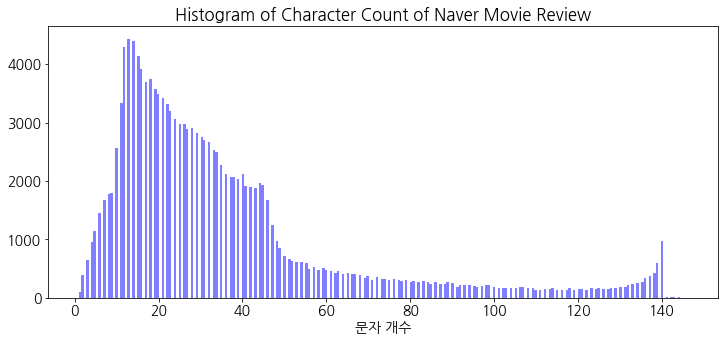

In [11]:
plt.figure(figsize=(12,5))
plt.hist(train_df['char_cnt'], bins=250, alpha=0.5, color='b', label='word')
plt.title('Histogram of Character Count of Naver Movie Review')
plt.xlabel('문자 개수')

/tmp/ipykernel_48113/2969202282.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


Text(0.5, 0, '단어 개수')

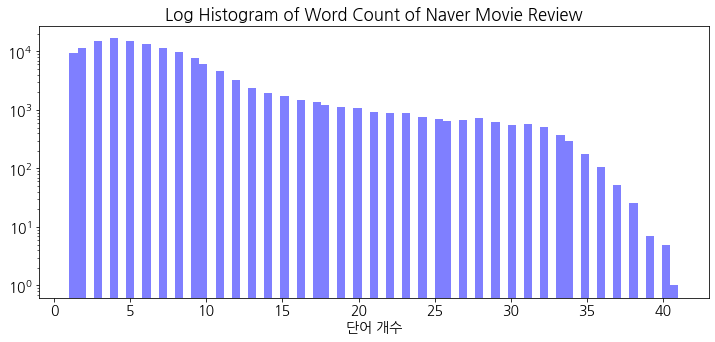

In [12]:
plt.figure(figsize=(12,5))
plt.hist(train_df['word_cnt'], bins=75, alpha=0.5, color='b', label='train')
plt.yscale('log', nonposy='clip')
plt.title('Log Histogram of Word Count of Naver Movie Review')
plt.xlabel('단어 개수')

워드 클라우드로 자주 등장하는 단어들을 확인합니다. `영화, 진짜, 너무, 정말` 등의 단어들이 많이 사용된 것을 확인할 수 있습니다.

In [13]:
%%time
train_review = [row for row in train_df['document'] if type(row) is str]
wordcloud = WordCloud(font_path='/usr/share/fonts/nanum/NanumGothic.ttf').generate(' '.join(train_review))

CPU times: user 11.1 s, sys: 509 ms, total: 11.6 s
Wall time: 11.8 s


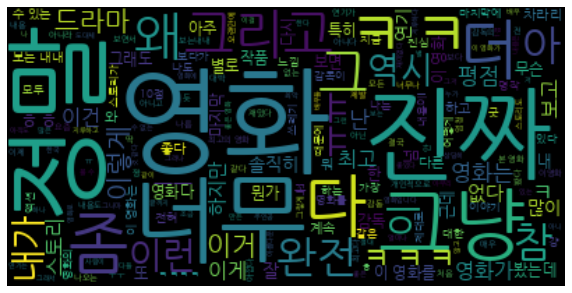

In [14]:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

기본 통계를 확인해 봅니다. 

In [15]:
def print_basic_stats(df, col_name):
    print('===== {} ====='.format(col_name))
    print('Maximum: {}'.format(np.max(df[col_name])))
    print('Minimum: {}'.format(np.min(df[col_name])))
    print('Mean: {:.3f}'.format(np.mean(df[col_name])))    
    print('Stddev: {:.3f}'.format(np.std(df[col_name])))
    print('1st quartile: {}'.format(np.percentile(df[col_name], 25)))
    print('Median: {}'.format(np.median(df[col_name])))      
    print('3rd quartile: {}'.format(np.percentile(df[col_name], 75))) 
    
print_basic_stats(train_df, 'char_cnt')
print_basic_stats(train_df, 'word_cnt')    

===== char_cnt =====
Maximum: 146
Minimum: 1
Mean: 35.981
Stddev: 29.491
1st quartile: 16.0
Median: 27.0
3rd quartile: 43.0
===== word_cnt =====
Maximum: 41
Minimum: 1
Mean: 7.744
Stddev: 6.518
1st quartile: 4.0
Median: 6.0
3rd quartile: 9.0


클래스 균형을 확인합니다. 본 데이터는 거의 1:1 비율을 보여주고 있지만, 실제 데이터는 95:5 같은 불균형 데이터들도 많다는 점을 숙지해 주세요.

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

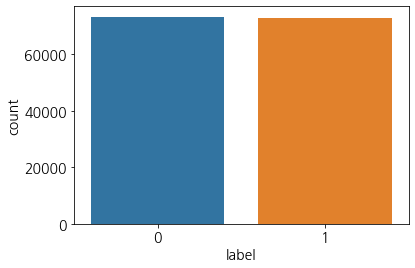

In [16]:
import seaborn as sns
sns.countplot(train_df['label'])

In [17]:
train_df['label'].value_counts()

0    73342
1    72840
Name: label, dtype: int64

# 4. 데이터 저장

데이타를 `레이블`,`리뷰` 형태의 Train, Test 파일을 생성 합니다.
```
0,  아 더빙.. 진짜 짜증나네요 목소리
1   흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
```

또한, 본 노트북에서는 정규식을 활용하여 탭(tab) 문자, 구두점(punctuation) 문자, 한글 문자가 아닌 문자를 제거하는 간단한 전처리를 수행해 보겠습니다.

In [18]:
import os
def read_nsmc_split(corpus_path, output_dir, output_path):
    import re
    
    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"corpus_path : {corpus_path}")
    logger.info(f"output_dir : {output_dir}")    
    logger.info(f"output_path : {output_path}")        
    
    with open(corpus_path, 'r', encoding='utf-8') as f, \
        open(output_path, 'w', encoding='utf-8') as fw:
        next(f)

        for line in f:
            # Remove tab
            _, sentence, label = line.strip().split('\t')             
            # Remove punctuations
            sentence = re.sub('[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]', ' ', sentence)
            # Remove non-Korean characters
            sentence = re.sub('[^가-힣ㄱ-하-ㅣ\\s]', '', sentence)

            if not sentence: continue                
            fw.writelines(label + ','+ sentence + '\n')    


## 4.2. 학습 데이터 전처리 수행

In [19]:
import config

train_corpus_path = f'{config.raw_data_dir}/ratings_train.txt'
#output_path = f'{config.train_data_dir}/ratings_train_preprocessd'
local_train_output_path = f'{config.train_data_dir}/ratings_train.txt'
read_nsmc_split(train_corpus_path, config.train_data_dir, local_train_output_path)

corpus_path : data/nsmc/rawdata//ratings_train.txt
output_dir : data/nsmc/train
output_path : data/nsmc/train/ratings_train.txt


In [20]:
! head -n3 {local_train_output_path}

0,아 더빙   진짜 짜증나네요 목소리
1,흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나
0,너무재밓었다그래서보는것을추천한다


## 4.3. 테스트 데이터 전처리 수행

In [21]:
test_corpus_path = f'{config.raw_data_dir}/ratings_test.txt'
#output_path = f'{config.train_data_dir}/ratings_train_preprocessd'
local_test_output_path = f'{config.test_data_dir}/ratings_test.txt'
read_nsmc_split(test_corpus_path, config.test_data_dir, local_test_output_path)

corpus_path : data/nsmc/rawdata//ratings_test.txt
output_dir : data/nsmc/test
output_path : data/nsmc/test/ratings_test.txt


In [22]:
! head -n3 {local_test_output_path}

1,굳 ㅋ
0,뭐야 이 평점들은     나쁘진 않지만 점 짜리는 더더욱 아니잖아
0,지루하지는 않은데 완전 막장임    돈주고 보기에는    


# 5. S3 데이터 업로딩

In [23]:
import sagemaker
sess = sagemaker.Session()

default_bucket = True
if default_bucket:
    bucket = sess.default_bucket()
else:
    bucket = "<Type Your Bucket Name>"
   
logger.info(f"bucket: {bucket}")
    

bucket: sagemaker-us-east-1-057716757052


In [24]:

train_channel = config.project_prefix + '/data/train'
test_channel = config.project_prefix + '/data/test'

sess.upload_data(path=f'{local_train_output_path}', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=f'{local_test_output_path}', bucket=bucket, key_prefix=test_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_test_data = 's3://{}/{}'.format(bucket, test_channel)

모델 아티팩트(Model Artifact)가 저장될 S3의 경로를 설정합니다.

In [25]:
logger.info(f's3_train_data: \n {s3_train_data}')
logger.info(f's3_test_data: \n {s3_test_data}')

s3_train_data: 
 s3://sagemaker-us-east-1-057716757052/sm_hugging_nsmc/data/train
s3_test_data: 
 s3://sagemaker-us-east-1-057716757052/sm_hugging_nsmc/data/test


In [26]:
! aws s3 ls {s3_train_data} --recursive
! aws s3 ls {s3_test_data} --recursive

2022-06-18 03:19:11   13296169 sm_hugging_nsmc/data/train/ratings_train.txt
2022-06-18 03:19:11    4449062 sm_hugging_nsmc/data/test/ratings_test.txt


# 6. 변수 저장

In [27]:
%store local_train_output_path
%store local_test_output_path
%store s3_train_data
%store s3_test_data

Stored 'local_train_output_path' (str)
Stored 'local_test_output_path' (str)
Stored 's3_train_data' (str)
Stored 's3_test_data' (str)
